In [1]:
import os
import scipy.io as sio
# 切换到包含文件的目录
os.chdir('/Users/gengxingri/Desktop/Leetcodes/HUAWEI')

import numpy as np

from scipy.sparse import csc_matrix, identity
from scipy.sparse.linalg import eigsh, norm, spsolve, cg, minres
import scipy.sparse as sp
import scipy.sparse.linalg as sla

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time


In [2]:
# 读取.mat 文件

data = sio.loadmat('sts4098.mat')

A = data['Problem']['A'][0][0]
print(A.shape, type(A))

b = data['Problem']['b'][0][0]
print(b.shape, type(b))


(4098, 4098) <class 'scipy.sparse._csc.csc_matrix'>
(4098, 1) <class 'scipy.sparse._csc.csc_matrix'>


In [3]:
# Calculate the condition number
start_time = time.time()

# return eigenvalues that have the min and max abs values, respectively
eigval_max = eigsh(A, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A, k=1, which='SM', return_eigenvectors=False, tol=5)[0]
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)

end_time = time.time()
execution_time = end_time - start_time

print(f"Runing time：{execution_time} s")

3.022592653209348 307102503.2171754
Condition number based on eigenvalues: 101602345.55294712
Runing time：40.5219452381134 s


In [4]:
# Create the diagonal preconditioner
n = A.shape[0]
diag_A = A.diagonal()

D = csc_matrix((1 / np.sqrt(diag_A), (np.arange(n), np.arange(n))), shape=(n, n))

# Apply preconditioning
A_new = D.dot(A.dot(D))
b_new = D.dot(b) / norm(D.dot(b))

print(A_new.diagonal(), norm(b_new))


[1. 1. 1. ... 1. 1. 1.] 1.0


In [5]:
# Calculate the condition number

eigval_max = eigsh(A_new, k=1, which='LM', return_eigenvectors=False)[0]
eigval_min = eigsh(A_new, k=1, which='SM', return_eigenvectors=False)[0]
print(eigval_min, eigval_max)

condition_number = eigval_max / eigval_min

print("Condition number based on eigenvalues:", condition_number)


0.0007637590415245282 5.131452557277415
Condition number based on eigenvalues: 6718.679947846637


In [6]:
# Unique solution of Ax = b

x_unique = spsolve(A_new, b_new)
print(x_unique)

[-0.2228531  -0.0058359  -0.02932355 ... -0.32316517  0.00041375
  0.001666  ]


In [7]:
# CG mtheod
def conjugate_gradient_sparse(A, b, tol=1e-8, max_iter=1000):
    n = b.shape[0] 
    x = np.zeros(n).reshape((n,1))
    r = b - A @ x
    #print(r.shape, type(r))
    xk_cg =[]
    
    
    p = r.copy()
    r_norm_sq = np.dot(r.T,r)
    errors = []  # Initial error
    #print(x.shape, r_norm_sq.shape)

    for i in range(max_iter):
        Ap = A @ p
        alpha = r_norm_sq / np.dot(p.T, Ap)
        x = x + alpha * p
        r -= alpha * Ap
        
        r_norm_sq_new = np.dot(r.T, r)
        
        #print(r_norm_sq_new.shape)
        errors.append(np.sqrt(r_norm_sq_new))  # Append new error
        xk_cg.append(x)
        if np.sqrt(r_norm_sq_new) < tol:
            print(f"Converged after {i+1} iterations")
            return x, errors, xk_cg
        
        beta = r_norm_sq_new / r_norm_sq
        p = r + beta * p
        r_norm_sq = r_norm_sq_new
    
    print(f"Did not converge after {max_iter} iterations")
    return x, errors, xk_cg

# Solve using our CG implementation
start_time = time.time()

b_array = b_new.toarray()
x_cg, errors, xk = conjugate_gradient_sparse(A_new, b_array)

cg_time = time.time() - start_time

print(f"CG method took {cg_time:.4f} seconds")

# change the type of errors_cg and xk_cg
errors_cg = [arr[0][0] for arr in errors]
xk_cg = [np.reshape(arr,-1) for arr in xk]

Converged after 432 iterations
CG method took 0.1074 seconds


In [8]:
'''
# CG method

b_array = b_new.toarray()

errors_cg = []
xk_cg = []

def callback(xk):
    rk = b_array - A_new.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_cg.append(error_norm)
    xk_cg.append(xk)
    return np.linalg.norm(rk)

x_cg, info_cg = cg(A_new, b_array, tol=1e-8, callback=callback)

print(x_cg, info_cg)
print('\nEorrors of CG method:',errors_cg[0:5], '\nThe value of xk:', xk_cg[0:5])
'''

"\n# CG method\n\nb_array = b_new.toarray()\n\nerrors_cg = []\nxk_cg = []\n\ndef callback(xk):\n    rk = b_array - A_new.dot(xk).reshape(-1,1)\n    error_norm = np.linalg.norm(rk)\n    errors_cg.append(error_norm)\n    xk_cg.append(xk)\n    return np.linalg.norm(rk)\n\nx_cg, info_cg = cg(A_new, b_array, tol=1e-8, callback=callback)\n\nprint(x_cg, info_cg)\nprint('\nEorrors of CG method:',errors_cg[0:5], '\nThe value of xk:', xk_cg[0:5])\n"

In [9]:
'''
# Implementation of MINRES

def minres_method(A, b, tol):
    n = len(b)
    maxit = 5*n
    x0 = np.zeros(n).reshape((-1,1))
    x = x0.copy()
    r = b - A @ x0
    p0 = r.copy()
    s0 = A @ p0
    p1 = p0.copy()
    s1 = s0.copy()
    
    for iter in range(1, maxit + 1):
        p2 = p1.copy()
        p1 = p0.copy()
        s2 = s1.copy()
        s1 = s0.copy()
        
        alpha = np.dot(r.T, s1) / np.dot(s1.T, s1)
        x = x + alpha * p1
        r = r - alpha * s1
        
        if np.linalg.norm(r) < tol:
            break
        
        p0 = s1.copy()
        s0 = A @ s1
        beta1 = np.dot(s0.T, s1) / np.dot(s1.T, s1)
        p0 = p0 - beta1 * p1
        s0 = s0 - beta1 * s1
        
        if iter > 1:
            beta2 = np.dot(s0.T, s2) / np.dot(s2.T, s2)
            p0 = p0 - beta2 * p2
            s0 = s0 - beta2 * s2
    
    return x, r

x, res_norm = minres_method(A_new, b_array, tol=1e-8)
    
print(x, res_norm)
'''

'\n# Implementation of MINRES\n\ndef minres_method(A, b, tol):\n    n = len(b)\n    maxit = 5*n\n    x0 = np.zeros(n).reshape((-1,1))\n    x = x0.copy()\n    r = b - A @ x0\n    p0 = r.copy()\n    s0 = A @ p0\n    p1 = p0.copy()\n    s1 = s0.copy()\n    \n    for iter in range(1, maxit + 1):\n        p2 = p1.copy()\n        p1 = p0.copy()\n        s2 = s1.copy()\n        s1 = s0.copy()\n        \n        alpha = np.dot(r.T, s1) / np.dot(s1.T, s1)\n        x = x + alpha * p1\n        r = r - alpha * s1\n        \n        if np.linalg.norm(r) < tol:\n            break\n        \n        p0 = s1.copy()\n        s0 = A @ s1\n        beta1 = np.dot(s0.T, s1) / np.dot(s1.T, s1)\n        p0 = p0 - beta1 * p1\n        s0 = s0 - beta1 * s1\n        \n        if iter > 1:\n            beta2 = np.dot(s0.T, s2) / np.dot(s2.T, s2)\n            p0 = p0 - beta2 * p2\n            s0 = s0 - beta2 * s2\n    \n    return x, r\n\nx, res_norm = minres_method(A_new, b_array, tol=1e-8)\n    \nprint(x, res_no

In [10]:
# MINRES method

errors_minres = []

xk_minres = []

def callback(xk):
    rk = b_array - A_new.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_minres.append(error_norm)
    xk_minres.append(xk)
    return np.linalg.norm(rk)

x_minres, info_minres = minres(A_new, b_array, tol=1e-11, callback=callback)
print(x_minres, info_minres)
print('\n',errors_minres[0:5])

[-0.22285311 -0.00583591 -0.02932355 ... -0.32316517  0.00041375
  0.001666  ] 0

 [0.6744782346878424, 0.5943996754202758, 0.540856840521053, 0.4710173677383129, 0.4075066667624153]


In [11]:
#errors_minres[0], np.linalg.norm(xk_minres[0]), np.log10(errors_minres[0]/ np.linalg.norm(xk_minres[0]))

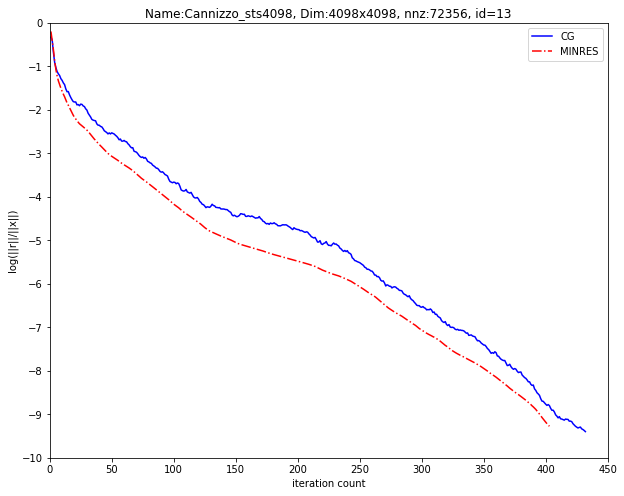

In [12]:
# Plot the log(||r||/||x||) errors

def plot_log(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||r||/||x||)')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=13')

    # Set y-axis limits
    ax.set_xlim(0, 450)
    ax.set_ylim(-10, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
xk_cg_norms =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norms =  np.array([np.linalg.norm(xk) for xk in xk_minres])

cg_errors_norm1 = np.log10(errors_cg / xk_cg_norms) 
minres_errors_norm1 = np.log10(errors_minres / xk_minres_norms)



plot_log(cg_errors_norm1, minres_errors_norm1)

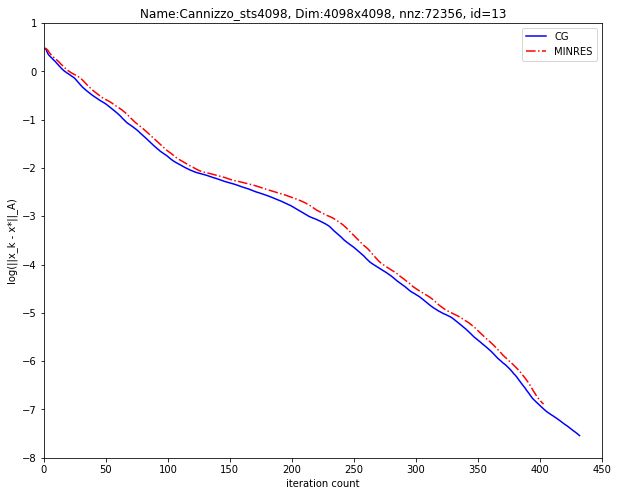

In [13]:
# Plot the log(||xk-x*||_A) errors

def plot_A_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||x_k - x*||_A)')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=13')

    # Set y-axis limits
    ax.set_xlim(0, 450)
    ax.set_ylim(-8, 1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* ||_A in each iteration

errors_iter_cg = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_cg]
xk_A_norms_cg = [np.array(err) for err in errors_iter_cg]

#print('\nErrors of cg:', xk_A_norms_cg[0:5])
cg_errors_A_norm = np.log10(xk_A_norms_cg)



# errors of minres

errors_iter_minres = [np.sqrt((xk - x_unique).T.dot(A_new.dot(xk - x_unique))) for xk in xk_minres] # list of array
xk_A_norms_minres = [np.array(err) for err in errors_iter_minres]
minres_errors_A_norm = np.log10(xk_A_norms_minres)
#print('\nErrors of minres:', xk_A_norms_minres[0:5])


# plot
plot_A_norm(cg_errors_A_norm, minres_errors_A_norm)

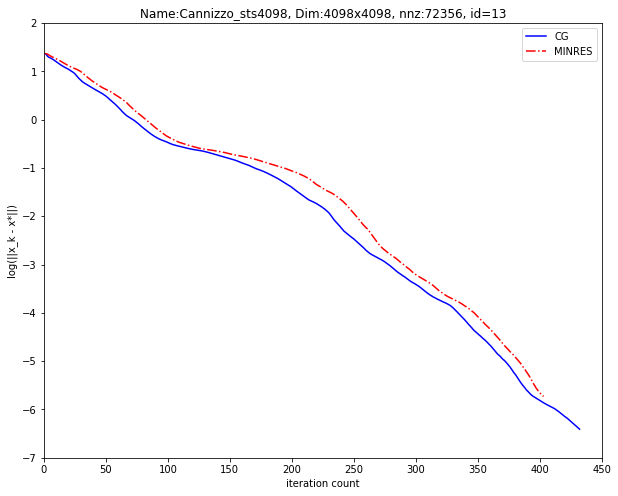

In [14]:
# Plot the log(||xk-x*||) errors

def plot_norm(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||x_k - x*||)')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=13')

    # Set y-axis limits
    ax.set_xlim(0, 450)
    ax.set_ylim(-7, 2)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

# errors of log||xk - x* || in each iteration

# errors of cg
errors3_cg = [np.linalg.norm(xk - x_unique) for xk in xk_cg]
errors_norm3_cg = [np.array(err) for err in errors3_cg]

#print('\nErrors of minres:', errors_norm3_cg[0:5])
cg_errors_norm3 = np.log10(errors_norm3_cg)



# errors of minres

errors3_minres = [np.linalg.norm(xk - x_unique) for xk in xk_minres]
errors_norm3_minres = [np.array(err) for err in errors3_minres]

#print('\nErrors of minres:', errors_norm3_minres[0:5])
minres_errors_norm3 = np.log10(errors_norm3_minres)

#print('\nErrors of minres:', minres_errors_norm3[0:5])


# plot
plot_norm(cg_errors_norm3, minres_errors_norm3)

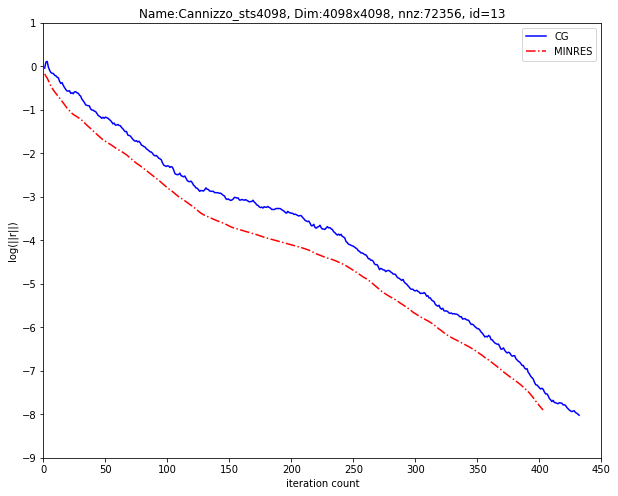

In [15]:
# Plot the log(||r||) errors

def plot_norm_4(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1, len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1, len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=13')

    # Set y-axis limits
    ax.set_xlim(0, 450)
    ax.set_ylim(-9, 1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()

    
# errors of log||r|| in each iteration

# errors of cg
cg_errors_norm4 = np.log10(errors_cg)



# errors of minres
minres_errors_norm4 = np.log10(errors_minres)



# plot
plot_norm_4(cg_errors_norm4, minres_errors_norm4)

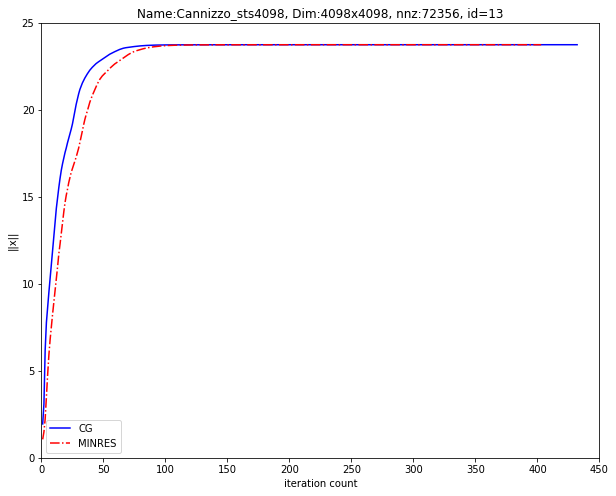

In [16]:
# Plot the ||x||

def plot_norm_5(cg_errors, minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(range(1,len(cg_errors)+1), cg_errors, 'b-', label='CG')
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'r-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('||x||')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=13')

    # Set y-axis limits
    ax.set_xlim(0, 450)
    ax.set_ylim(0, 25)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
xk_cg_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_cg])
xk_minres_norm5 =  np.array([np.linalg.norm(xk) for xk in xk_minres])

# plot
plot_norm_5(xk_cg_norm5, xk_minres_norm5)

In [17]:
A

<4098x4098 sparse matrix of type '<class 'numpy.float64'>'
	with 72356 stored elements in Compressed Sparse Column format>

In [18]:
# Now plot the indefinitesystem (A-\delta I)x = b, where\delta = 0.5

I = identity(n, format='csc')
A_indef = A_new - 0.5*I

# MINRES method

errors_minres_indef = []

xk_minres_indef = []

def callback(xk):
    rk = b_array - A_indef.dot(xk).reshape(-1,1)
    error_norm = np.linalg.norm(rk)
    errors_minres_indef.append(error_norm)
    xk_minres_indef.append(xk)
    return np.linalg.norm(rk)

x_indef_minres, info_indef_minres = minres(A_indef, b_array, tol=1e-11, callback=callback)
print(x_indef_minres, info_indef_minres)

[-0.27410838  1.94736414  1.03082389 ...  0.23216961 -0.01513121
 -0.32557819] 0


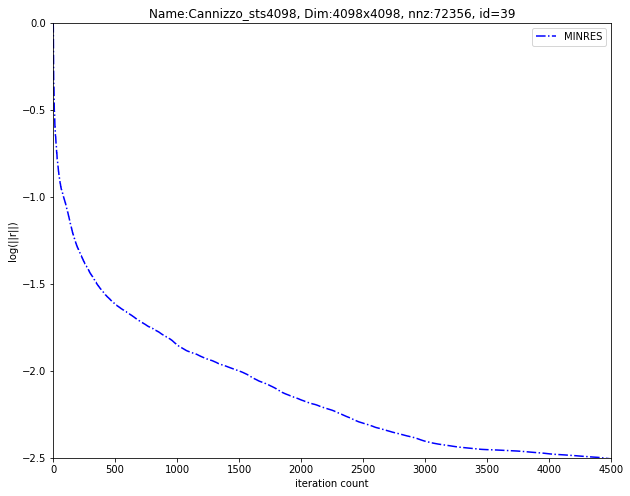

In [22]:
# Plot the log(||r||) errors

def plot_indef_log(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('log(||r||)')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=39')

    # Set y-axis limits
    ax.set_xlim(0, 4500)
    ax.set_ylim(-2.5, 0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    
    
errors_indef_minres =  np.array([np.linalg.norm(err) for err in errors_minres_indef])

minres_errors_indef = np.log10(errors_indef_minres)

# plot
plot_indef_log(minres_errors_indef)

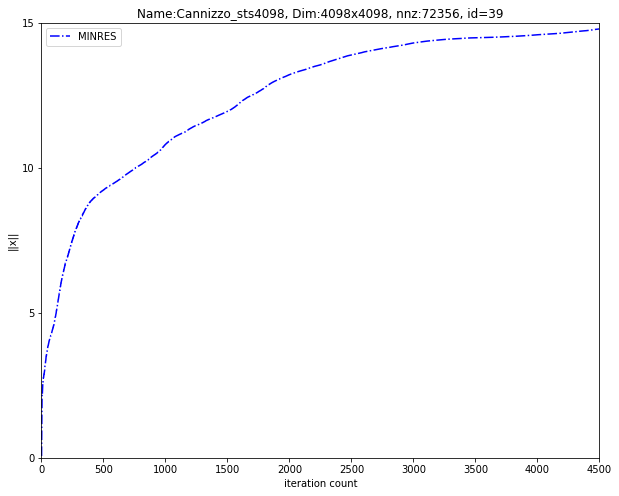

In [23]:
# Plot the ||x|| for the indefinite system

def plot_indef_norm(minres_errors):
    # Create the plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    ax.plot(range(1,len(minres_errors)+1), minres_errors, 'b-.', label='MINRES')

    # Set labels and title
    ax.set_xlabel('iteration count')
    ax.set_ylabel('||x||')
    ax.set_title('Name:Cannizzo_sts4098, Dim:4098x4098, nnz:72356, id=39')

    # Set y-axis limits
    ax.set_xlim(0, 4500)
    ax.set_ylim(0, 15)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

    # Add legend
    ax.legend()


    # Show the plot
    plt.show()
    
    

xk_minres_indef_norm =  np.array([np.linalg.norm(xk) for xk in xk_minres_indef])

# plot
plot_indef_norm(xk_minres_indef_norm)